In [19]:
import os
import numpy as np
import nibabel as nib
from sklearn.preprocessing import MinMaxScaler  # Importar MinMaxScaler
import random
import matplotlib.pyplot as plt
from tifffile import imwrite
from tensorflow.keras.utils import to_categorical


In [ ]:
# Definir el escalador
scaler = MinMaxScaler()

# Ruta al conjunto de datos de BraTS2024
TRAIN_DATASET_PATH = 'data/BraTS2025-GLI-PRE-Challenge-TrainingData/'

### Mostrar para una imagen

In [ ]:
# Función para cargar y escalar las imágenes de MRI
def load_and_scale_image(file_path):
    """
    Carga una imagen NIfTI (.nii/.nii.gz) y la escala usando MinMaxScaler.
    """
    # Cargar la imagen
    image = nib.load(file_path).get_fdata()
    
    # Escalar la imagen. Aplanamos la imagen a un vector para aplicar el escalado, 
    # luego la reconfiguramos a su forma original.
    image_scaled = scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)
    
    return image_scaled

# Cargar y escalar las imágenes de las distintas modalidades
# Estas son las modalidades del dataset BraTS2025 para este ejemplo

# FLAIR: T2 Fluid-Attenuated Inversion Recovery (similar a T2f)
test_image_flair = load_and_scale_image(TRAIN_DATASET_PATH + 'BraTS-GLI-00000-000/BraTS-GLI-00000-000-t2f.nii.gz')
print("T2f - FLAIR Image Max Value (after scaling):", test_image_flair.max())

# T1 Non-contrast: T1 sin contraste
test_image_t1 = load_and_scale_image(TRAIN_DATASET_PATH + 'BraTS-GLI-00000-000/BraTS-GLI-00000-000-t1n.nii.gz')
print("t1n - T1 Non-contrast Image Max Value (after scaling):", test_image_t1.max())

# T1 Contrast Enhanced: T1 con contraste
test_image_t1ce = load_and_scale_image(TRAIN_DATASET_PATH + 'BraTS-GLI-00000-000/BraTS-GLI-00000-000-t1c.nii.gz')
print("t1c - T1 Contrast Enhanced Image Max Value (after scaling):", test_image_t1ce.max())

# T2 Weighted: T2 ponderado
test_image_t2 = load_and_scale_image(TRAIN_DATASET_PATH + 'BraTS-GLI-00000-000/BraTS-GLI-00000-000-t2w.nii.gz')
print("t2w - T2 Weighted Image Max Value (after scaling):", test_image_t2.max())

# Cargar la máscara de segmentación
test_mask = nib.load(TRAIN_DATASET_PATH + 'BraTS-GLI-00000-000/BraTS-GLI-00000-000-seg.nii.gz').get_fdata()

# Asegurarnos de que la máscara esté en formato uint8 (para asegurar que las etiquetas sean de 0-255)
test_mask = test_mask.astype(np.uint8)

# Verificar las etiquetas presentes en la máscara
print("Unique mask values (before reencoding):", np.unique(test_mask))  # Deberían ser [0, 1, 2, 4]

T2f - FLAIR Image Max Value (after scaling): 1.0
t1n - T1 Non-contrast Image Max Value (after scaling): 1.0
t1c - T1 Contrast Enhanced Image Max Value (after scaling): 1.0
t2w - T2 Weighted Image Max Value (after scaling): 1.0
Unique mask values (before reencoding): [0 1 2 3]


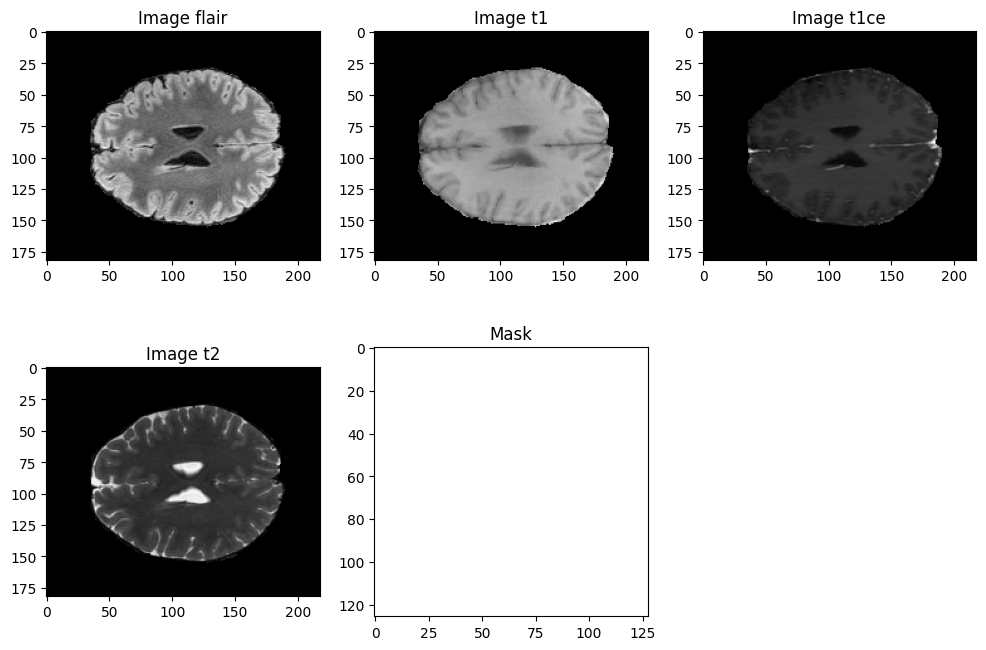

In [28]:
# Mostrar una imagen aleatoria
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

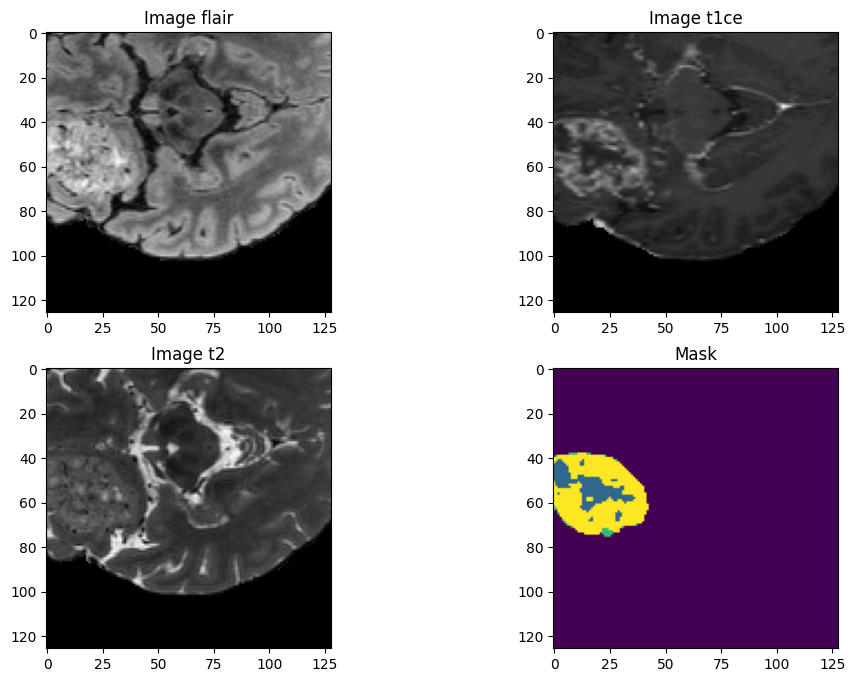

In [13]:
'''Combining all 4 images to 4 channels of a numpy array.
Combine t1ce, t2, and flair into single multichannel image
'''
combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)

combined_x=combined_x[56:184, 56:184, 13:141] #Crop to 128x128x128x4

test_mask = test_mask[56:184, 56:184, 13:141]#The same for mask


n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(combined_x[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(combined_x[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(combined_x[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [29]:
# Asegurarse de que el directorio de salida exista
output_dir = 'data/BraTS2025-GLI-PRE-Challenge-TrainingData-Combined/'
os.makedirs(output_dir, exist_ok=True)

# Guardar archivos multicanal como .tif y .npy
imwrite(os.path.join(output_dir, 'combined-0000-000.tif'), combined_x)
np.save(os.path.join(output_dir, 'combined-0000-000.npy'), combined_x)  # Guardar como np array

# Cargar el archivo guardado como ejemplo
my_img = np.load(os.path.join(output_dir, 'combined-0000-000.npy'))

# Convertir la máscara a formato categórico
test_mask = to_categorical(test_mask, num_classes=4)


### Todas las imágenes